# Tests for quering local PBF osm files

guide for using the filter https://pypi.org/project/esy-osmfilter/


## imports

In [1]:
import configparser, contextlib
import os, sys

from esy.osmfilter import osm_colors as CC
from esy.osmfilter import run_filter 
from esy.osmfilter import Node, Way, Relation

import urllib.request


## Get file

In [2]:
city_name = 'liechtenstein-latest'
c = 'berlin-latest'

In [3]:
PBF_inputfile = os.path.join(os.getcwd(), f'test-osmfilter/{city_name}.osm.pbf')
JSON_outputfile = os.path.join(os.getcwd(), f'test-osmfilter/{city_name}.json')

In [4]:
PBF_inputfile

'/home/laia/code/Laiagdla/livablestreets/notebooks/test-osmfilter/liechtenstein-latest.osm.pbf'

In [6]:
if not os.path.exists(f'test-osmfilter/{city_name}.osm.pbf'):
    filename, headers = urllib.request.urlretrieve(
        f'https://download.geofabrik.de/europe/{city_name}.osm.pbf',
        filename=f'test-osmfilter/{city_name}.osm.pbf')
# PBF_inputfile = filename

## Filter main data

In [134]:
prefilter   = {Node: {}, Way: {"man_made":["pipeline",],}, Relation: {}}
blackfilter = [("pipeline","substation"),]
whitefilter = [(('man_made','pipeline'),('waterway','drain')),] #[(("waterway","drain"),("name","Wäschgräble")), ]

In [135]:
>>> [Data,_]=run_filter('noname',
...                     PBF_inputfile, 
...                     JSON_outputfile, 
...                     prefilter,
...                     whitefilter, 
...                     blackfilter, 
...                     NewPreFilterData=True, 
...                     CreateElements=False, 
...                     LoadElements=False,
...                     verbose=True)

INFO:esy.osmfilter.pre_filter:PreFilter OSM GAS DATA
INFO:esy.osmfilter.pre_filter:InputFile     : /home/laia/code/Laiagdla/livablestreets/notebooks/test-osmfilter/liechtenstein-latest.osm.pbf
INFO:esy.osmfilter.pre_filter:Size          : 2692            kbyte
INFO:esy.osmfilter.pre_filter:Estimated Time: 0.38            s
INFO:esy.osmfilter.pre_filter:=============================
INFO:esy.osmfilter.pre_filter:0.5
INFO:esy.osmfilter.pre_filter:1
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:

In [136]:
>>> len(Data['Node'])

203

In [137]:
>>> len(Data['Relation'])

0

In [141]:
>>> len(Data['Way'])

45

In [142]:
Data['Way']

{'46796846': {'id': 46796846,
  'tags': {'location': 'underground',
   'man_made': 'pipeline',
   'name': 'Wäschgräbli',
   'waterway': 'drain'},
  'refs': [275133472, 597910238, 597910239]},
 '46796872': {'id': 46796872,
  'tags': {'layer': '-1',
   'location': 'underground',
   'man_made': 'pipeline',
   'name': 'Wäschgräble',
   'waterway': 'drain'},
  'refs': [597910240,
   597910249,
   597910250,
   597910251,
   597910252,
   597910253,
   4781273464,
   597910254,
   599012412,
   597757327]},
 '1031290326': {'id': 1031290326,
  'tags': {'layer': '-1',
   'location': 'underground',
   'man_made': 'pipeline',
   'operator': 'Liechtensteinische Kraftwerke',
   'substance': 'water'},
  'refs': [9505035225,
   9505025758,
   9505035231,
   9505035232,
   9505035233,
   9505035234,
   9505035235,
   9505035236,
   9505035237,
   9505035238,
   9505035239,
   9505035240,
   9505035241,
   9505035242,
   9505035243,
   9505035244,
   9505035245,
   9505035246,
   9505035247,
   950503

## Filter out (blackfilter)

In [143]:
>>> [_,Elements]=run_filter('funny-waterway-pipelines',
...                            PBF_inputfile, 
...                            JSON_outputfile, 
...                            prefilter,
...                            whitefilter, 
...                            blackfilter, 
...                            NewPreFilterData=False, 
...                            CreateElements=True, 
...                            LoadElements=False,
...                            verbose=True)
>>> len(Elements['funny-waterway-pipelines'])
0
>>> len(Elements['funny-waterway-pipelines']['Relation'])
0
>>> len(Elements['funny-waterway-pipelines']['Way'])

2

In [144]:
Elements

{'funny-waterway-pipelines': {'Node': {},
  'Way': {'46796872': {'id': 46796872,
    'tags': {'layer': '-1',
     'location': 'underground',
     'man_made': 'pipeline',
     'name': 'Wäschgräble',
     'waterway': 'drain'},
    'refs': [597910240,
     597910249,
     597910250,
     597910251,
     597910252,
     597910253,
     4781273464,
     597910254,
     599012412,
     597757327]},
   '46796846': {'id': 46796846,
    'tags': {'location': 'underground',
     'man_made': 'pipeline',
     'name': 'Wäschgräbli',
     'waterway': 'drain'},
    'refs': [275133472, 597910238, 597910239]}},
  'Relation': {}}}

## save geojson

In [145]:
>>> from esy.osmfilter import export_geojson
>>> export_geojson(Elements['funny-waterway-pipelines']['Way'],Data,
... filename=f'test-osmfilter/{city_name}.geojson',jsontype='Line')

## open geosjon

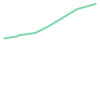

In [148]:
import geopandas as gpd
elements = gpd.read_file(f'test-osmfilter/{city_name}.geojson')
elements['geometry'][0]

In [149]:
elements

,layer,location,man_made,name,waterway,geometry
0,-1,underground,pipeline,Wäschgräble,drain,"LINESTRING (9.50193 47.15554, 9.50272 47.15567..."
1,None,underground,pipeline,Wäschgräbli,drain,"LINESTRING (9.50223 47.15343, 9.50230 47.15356..."


# shapely, create geometry from geojson

In [150]:
import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize

# test

In [192]:
green = {#'landuse':['grass','forest','orchard','allotments','cementery','flowerbed', 'meadow','greenfield', 'recreation_ground','village_green'],
         #'leisure':['park','playground','garden'],
         'natural':['heath','shrubbery','wood','grassland'],}

prefilter   = {Node: {}, Way: green, Relation: {}}


[Data,_]=run_filter('noname',
                    PBF_inputfile, 
                    JSON_outputfile, 
                    prefilter,
                    whitefilter, 
                    blackfilter, 
                    NewPreFilterData=True, 
                    CreateElements=False, 
                    LoadElements=False,
                    verbose=True)

INFO:esy.osmfilter.pre_filter:PreFilter OSM GAS DATA
INFO:esy.osmfilter.pre_filter:InputFile     : /home/laia/code/Laiagdla/livablestreets/notebooks/test-osmfilter/liechtenstein-latest.osm.pbf
INFO:esy.osmfilter.pre_filter:Size          : 2692            kbyte
INFO:esy.osmfilter.pre_filter:Estimated Time: 0.38            s
INFO:esy.osmfilter.pre_filter:=============================
INFO:esy.osmfilter.pre_filter:0.5
INFO:esy.osmfilter.pre_filter:1
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:

INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfi

In [193]:
>>> len(Data['Way'])

291

In [194]:
export_geojson(Data['Way'],Data,
filename=f'test-osmfilter/{city_name}.geojson',jsontype='Line')

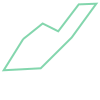

In [195]:
elements = gpd.read_file(f'test-osmfilter/{city_name}.geojson')
elements['geometry'][1]

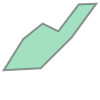

In [196]:
Polygon(elements['geometry'][1])

In [197]:
lis = []
for l in elements['geometry']:
    lis.append(l)

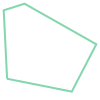

In [198]:
lis[2]

In [199]:
merged = linemerge([*lis])  # merge LineStrings
borders = unary_union(merged)  # linestrings to a MultiLineString
polygons = list(polygonize(borders))
parks = geometry.MultiPolygon(polygons)

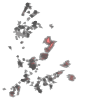

In [200]:
parks

In [203]:
import folium
from shapely.geometry import mapping


In [204]:
map_test = folium.Map(width=750,height=500,tiles="openstreetmap",   zoom_start=15)
folium.GeoJson(mapping(parks)).add_to(map_test)

In [205]:
map_test